In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
%matplotlib inline

import glob
import os
import random

In [2]:
df = pd.DataFrame()

male = [0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 13, 14, 17, 21, 23, 24, 27, 28, 29, 30, 33, 36, 37, 41, 42, 43, 44, 46, 48, 50, 51, 53, 56, 58, 59, 60, 61]
female = [4, 5, 8, 15, 16, 18, 19, 20, 22, 25, 26, 31, 32, 34, 35, 38, 39, 40, 45, 47, 49, 52, 54, 55, 57, 62]

for csv in glob.glob('./raw_subset/*.csv'):
    id = os.path.splitext(os.path.basename(csv))[0]
    new = pd.DataFrame(pd.read_csv(csv, header=None, skiprows=[0])).iloc[:, :-2]
    new['id'] = id
    new['gender'] = 'm' if int(id) + 1 in male else 'f'
    df = df.append(new)

columns = list(pd.read_csv('./raw_subset/1.csv', header=0).columns[:-2]) + ['id', 'gender']
df.columns = columns
df.set_index(['id', 'index'], inplace=True)

In [3]:
df.head(2)

time   L_x  L_y  L_z   C_x  C_y  C_z  F_x  F_y  F_z  ...  \
id index                                                        ...   
6  1      0.000   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  1.0  ...   
   2      0.063 -15.5  2.1 -4.1 -19.8  2.0 -4.2  1.0  0.0  0.0  ...   

          circle_3d_normal_y  circle_3d_normal_z  circle_3d_radius     theta  \
id index                                                                       
6  1                0.372906           -0.926503      3.910000e-08  1.952935   
   2                0.372906           -0.926503      3.930000e-08  1.952935   

               phi  projected_sphere_center_x  projected_sphere_center_y  \
id index                                                                   
6  1     -1.625059                  353.67621                  -9.542156   
   2     -1.625059                  353.67621                  -9.542156   

          projected_sphere_axis_a  projected_sphere_axis_b  gender  
id index                                                            
6  1                  1338.365184              1338.365184       m  
   2                  1338.365184              1338.365184       m  

[2 rows x 42 columns]

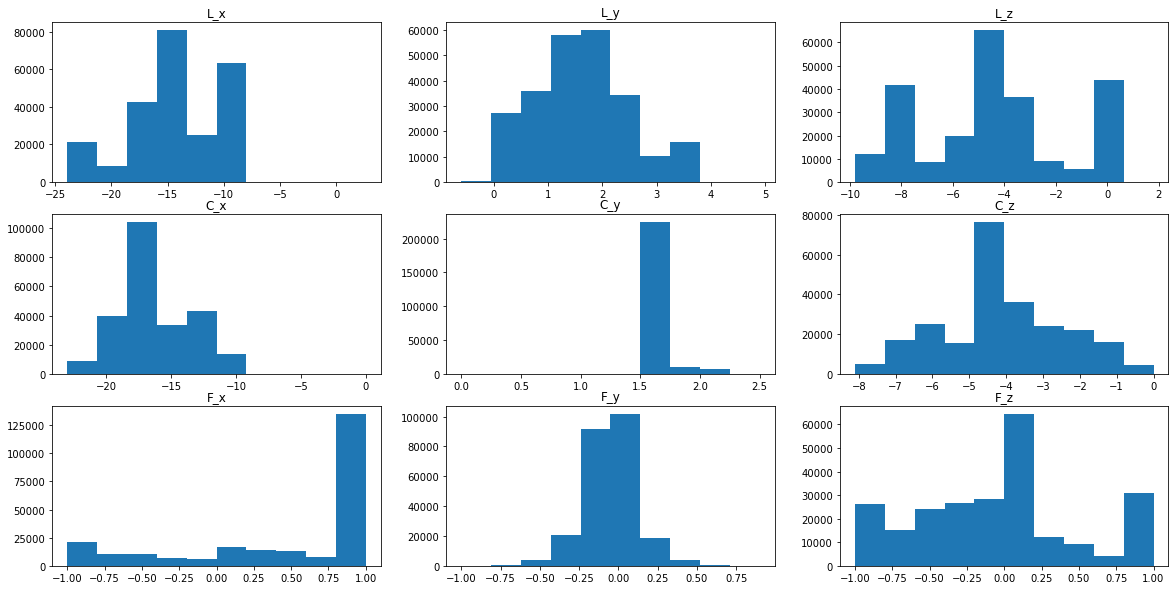

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(20,10))
for i, col in enumerate(df.columns[1:10]):
  axs[i//3, i%3].hist(df[col])
  axs[i//3, i%3].set_title(col)

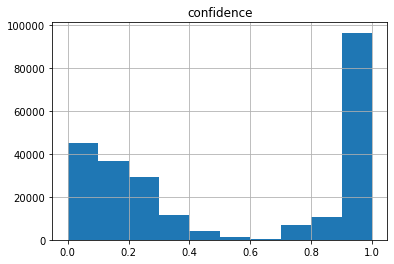

In [5]:
df.hist(column='confidence');

In [6]:
relevant = ['time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z', 'confidence', 'gender']
df = df[relevant]

In [7]:
df.head()

time   L_x  L_y  L_z   C_x  C_y  C_z  confidence gender
id index                                                          
6  1      0.000   0.0  0.0  0.0   0.0  0.0  0.0    1.000000      m
   2      0.063 -15.5  2.1 -4.1 -19.8  2.0 -4.2    0.919445      m
   3      0.095 -15.5  2.1 -4.1 -19.8  2.0 -4.2    0.876950      m
   4      0.128 -15.5  1.9 -4.1 -19.8  1.7 -4.2    0.861915      m
   5      0.196 -15.5  1.9 -4.1 -19.8  1.7 -4.2    0.883676      m

In [8]:
# Drop repeated consecutive times (drop first)
df = df.loc[df['time'].shift() != df['time']]

# Drop row at time 0.000 (index 1) as these are not accurate
df = df.loc[df['time'] != 0.000]

# Keep only confident eye tracking coords for eye path analysis
df_eye = df[df['confidence'] > 0.6]

# Remove some outlier PoG eye measurments (some are outside of the room coordinates)
df_eye = df_eye[(df_eye['L_x'] >= -23.9) & (df_eye['L_x'] <= -9)]
df_eye = df_eye[(df_eye['L_y'] >= 0) & (df_eye['L_y'] <= 3.7)]
df_eye = df_eye[(df_eye['L_z'] >= -9.7) & (df_eye['L_z'] <= 0.4)]

df.drop(['L_x', 'L_y', 'L_z'], axis=1, inplace=True)
df_eye.drop(['time', 'C_x', 'C_y', 'C_z', 'confidence', 'gender'], axis=1, inplace=True)



In [9]:
df = pd.merge(df.reset_index(), df_eye.reset_index(), how='left', on=['id', 'index']).set_index(keys=['id', 'index'])

In [10]:
df.tail(20)

time   C_x  C_y  C_z  confidence gender   L_x  L_y  L_z
id index                                                           
59 4246   119.68 -18.0  1.7 -4.9    0.091526      m   NaN  NaN  NaN
   4247   119.71 -18.0  1.7 -4.9    0.091526      m   NaN  NaN  NaN
   4249   119.75 -18.0  1.7 -4.9    0.990000      m -12.2  3.5 -5.2
   4250   119.78 -18.0  1.7 -4.9    0.237456      m   NaN  NaN  NaN
   4251   119.82 -18.0  1.7 -4.9    0.224075      m   NaN  NaN  NaN
   4253   119.85 -18.0  1.7 -4.9    0.990000      m -11.8  3.4 -5.2
   4254   119.88 -18.0  1.7 -4.9    1.000000      m -11.8  3.4 -5.2
   4255   119.91 -18.0  1.7 -4.9    1.000000      m -11.8  3.4 -5.2
   4257   119.94 -18.0  1.7 -4.9    1.000000      m -12.0  3.5 -5.2
   4258   119.98 -18.0  1.7 -4.9    1.000000      m -11.9  3.5 -5.2
   4259   120.01 -18.0  1.7 -4.9    1.000000      m -11.9  3.5 -5.2
   4261   120.04 -18.0  1.7 -4.9    0.304478      m   NaN  NaN  NaN
   4262   120.07 -18.0  1.7 -4.9    0.200339      m   NaN  NaN  NaN
   4263   120.11 -18.0  1.7 -4.9    0.200339      m   NaN  NaN  NaN
   4265   120.14 -18.0  1.7 -4.9    1.000000      m -11.9  3.5 -5.5
   4266   120.17 -18.0  1.7 -4.9    1.000000      m -11.9  3.5 -5.5
   4267   120.21 -18.0  1.7 -4.9    1.000000      m -11.9  3.5 -5.5
   4268   120.24 -18.0  1.7 -4.9    1.000000      m -11.9  3.5 -5.5
   4269   120.28 -18.0  1.7 -4.9    1.000000      m -11.9  3.5 -5.4
   4270   120.31 -18.0  1.7 -4.9    1.000000      m -12.6  3.3 -5.4

In [11]:
# Camera Y position should be fixed (only variance comes from jitter and is not relevant for analysis)
df.drop('C_y', axis=1, inplace=True)

## Metrics

In [12]:
import math
def distance_3d(x1, y1, z1, x2, y2, z2):
  return math.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)

def distance_2d(x1, z1, x2, z2):
  return math.sqrt((x2-x1)**2 + (z2-z1)**2)

In [13]:
C_metrics = {}

In [14]:
for id in df.reset_index().id.unique():
  user_df = df.loc[id]
  pt = user_df.iloc[0, 0]
  px, pz = user_df.iloc[0, 1:3]

  distances = []
  velocities = []
  times = []
  for j in range(1, len(user_df.iloc[1:, 1:3]) + 1):
    x, z = user_df.iloc[j, 1:3]
    t = user_df.iloc[j, 0]
    d = distance_2d(px, pz, x, z)
    distances.append(d)
    velocities.append(d / (t - pt))
    times.append(t)
    pt = t
    px, pz = x, z

  C_metrics[id] = {'v': velocities, 't': times, 'step_d': distances}

# Camera Movement Analysis

From stepwise velocity through path segmentations and straightness/sinuosity

In [15]:
random.seed(747)
sample = random.sample(C_metrics.keys(), 10)

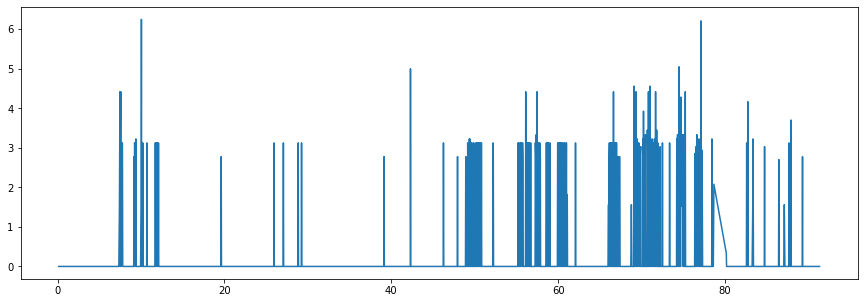

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
# for k, v in C_velocities.items():
ax.plot(C_metrics['5']['t'], C_metrics['5']['v'])

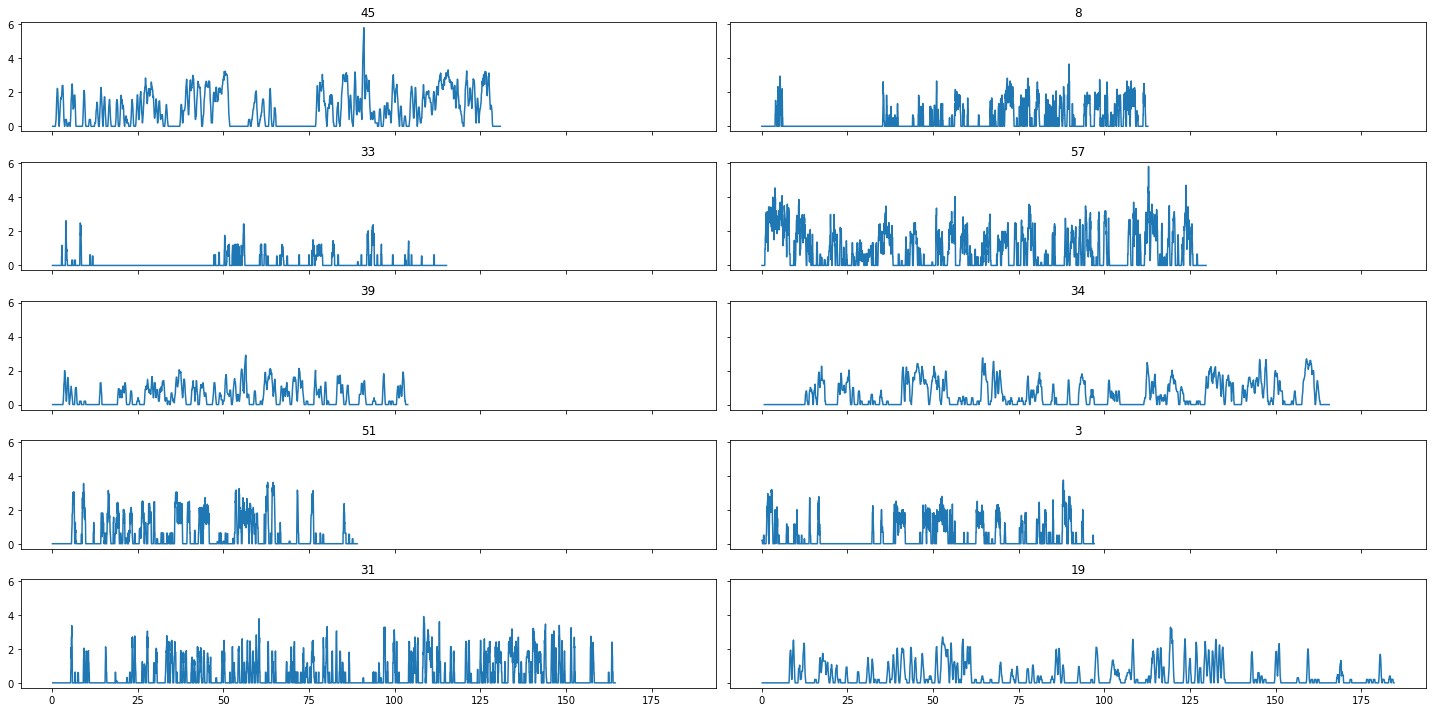

In [17]:
# Plot smoothed moving average speeds
window = 5

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

for k in C_metrics.keys():
    C_metrics[k]['ma_v'] = moving_average(C_metrics[k]['v'], window)

fig, ax = plt.subplots(5, 2, figsize=(20,10), sharey=True, sharex=True)

for i, k in enumerate(sample):
    ax[i//ax.shape[1], i%ax.shape[1]].plot(C_metrics[k]['t'][:-window + 1], C_metrics[k]['ma_v'])
    ax[i//ax.shape[1], i%ax.shape[1]].set_title(k)

fig.tight_layout()

In [18]:
# Create path segmentations where users stay still for n seconds to look at something
# Type of simple change point analysis

# New paths start when movement begins again

# Number of seconds to break path on no movement
path_break = 1

for k, v in C_metrics.items():
    path_breaks = []
    last_motion = 0 # time of last motion
    waiting_for_next_motion = True
    for i, vel in enumerate(v['v']):
        if vel != 0:
            last_motion = v['t'][i]
            if waiting_for_next_motion:
                path_breaks.append(i)
                waiting_for_next_motion = False
        elif v['t'][i] - last_motion > path_break:
            waiting_for_next_motion = True
    path_breaks.append(len(v['v']))
    C_metrics[k]['path_breaks'] = path_breaks

print(C_metrics['3']['path_breaks'])

[1, 198, 260, 386, 456, 896, 967, 1069, 1285, 1645, 1742, 1876, 1979, 2101, 2240, 2406, 2608, 2698, 2711]


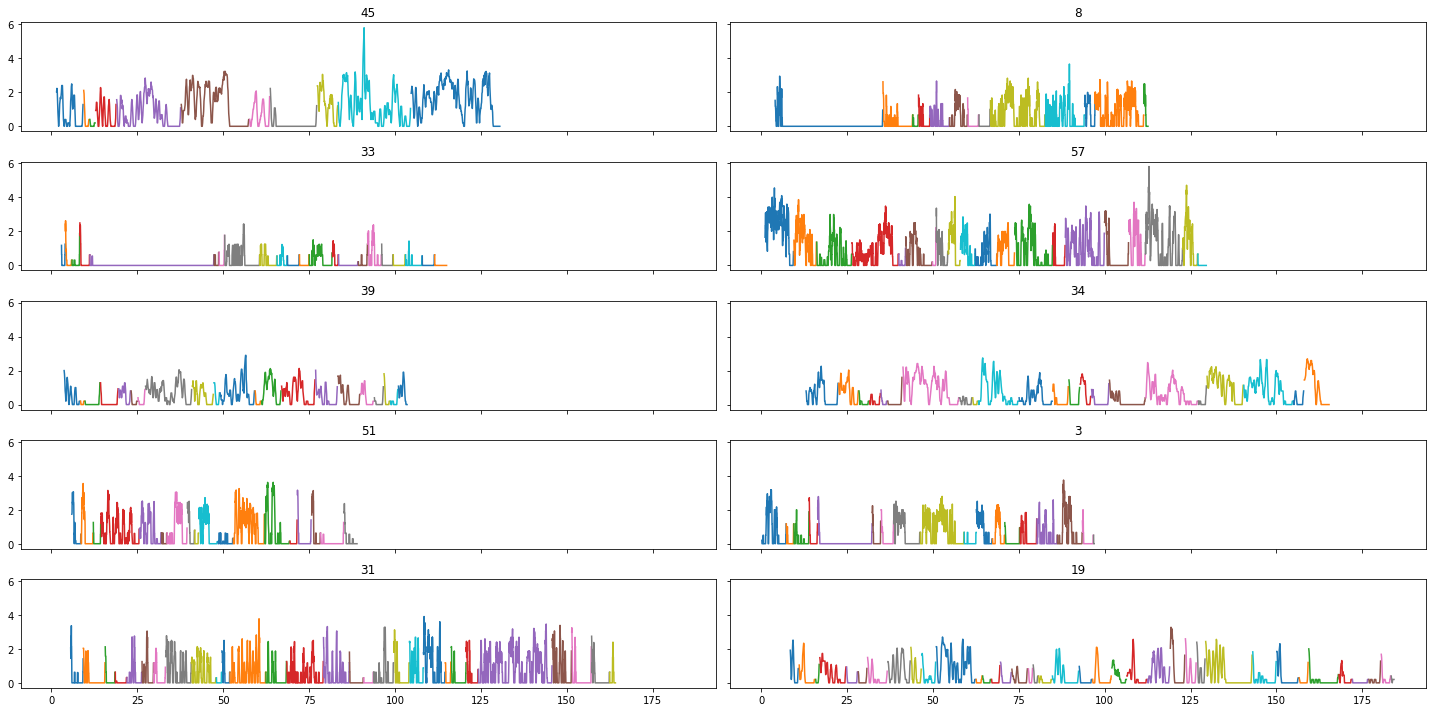

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(20,10), sharey=True, sharex=True)

# random.sample(C_velocities.keys(), ax.size)
# sorted(list(C_velocities.keys()), key=lambda x: int(x))[:ax.size]
for i, k in enumerate(sample):
    ex = C_metrics[k]
    for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
        path_end -= 1
        if path_end > len(ex['ma_v']):
            path_end -= window + 1
        ax[i//ax.shape[1], i%ax.shape[1]].plot(ex['t'][path_start:path_end], ex['ma_v'][path_start:path_end])
        ax[i//ax.shape[1], i%ax.shape[1]].set_title(k)
fig.tight_layout()

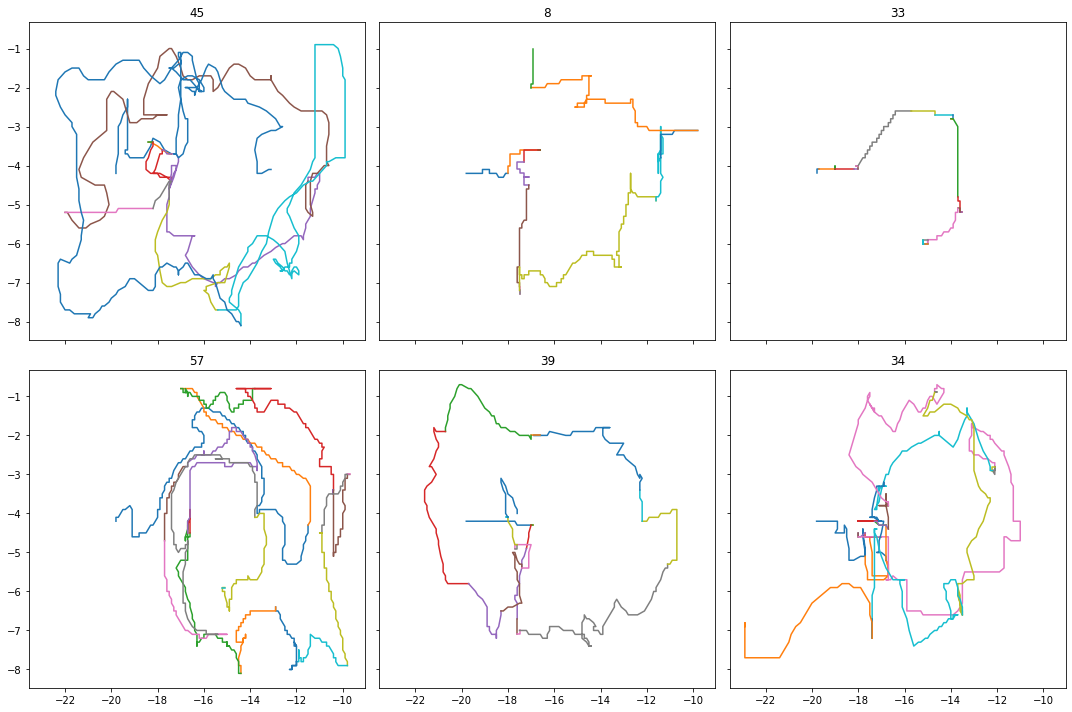

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(15,10), sharey=True, sharex=True)

for i, k in enumerate(sample[:ax.size]):
    ex = C_metrics[k]
    user_df = df.loc[k]
    for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
        path_end -= 1
        if path_end > len(ex['ma_v']):
            path_end -= window + 1
        
        ax[i//ax.shape[1], i%ax.shape[1]].plot(user_df['C_x'].iloc[path_start:path_end], user_df['C_z'].iloc[path_start:path_end])
        ax[i//ax.shape[1], i%ax.shape[1]].set_title(k)
fig.tight_layout()

In [21]:
# Straigtness calculated as D/L as per https://doi.org/10.1016/j.jtbi.2004.03.016
# Path velocities also calculated

for k, v in C_metrics.items():
    user_df = df.loc[k]
    straightness = []
    velocities = []
    lengths = []
    displacements = []
    times = []
    for path_start, path_end in zip(v['path_breaks'], v['path_breaks'][1:]):
        s, e = user_df.iloc[path_start], user_df.iloc[path_end - 1]
        D = distance_2d(s['C_x'], s['C_z'], e['C_x'], e['C_z'])
        L = 0
        for i in range(path_start, path_end):
            L += v['step_d'][i]
        straightness.append(D/L)
        # Exclude end 2+ seconds of stillness from the average velocity
        velocities.append(np.mean(v['v'][path_start:path_end][:np.max(np.nonzero(v['v'][path_start:path_end])) + 1]))
        lengths.append(L)
        displacements.append(D)
        times.append(e['time'] - s['time'])
    C_metrics[k]['path_straightness'] = straightness
    C_metrics[k]['path_velocities'] = velocities
    C_metrics[k]['path_lengths'] = lengths
    C_metrics[k]['path_displacements'] = displacements
    C_metrics[k]['path_times'] = times


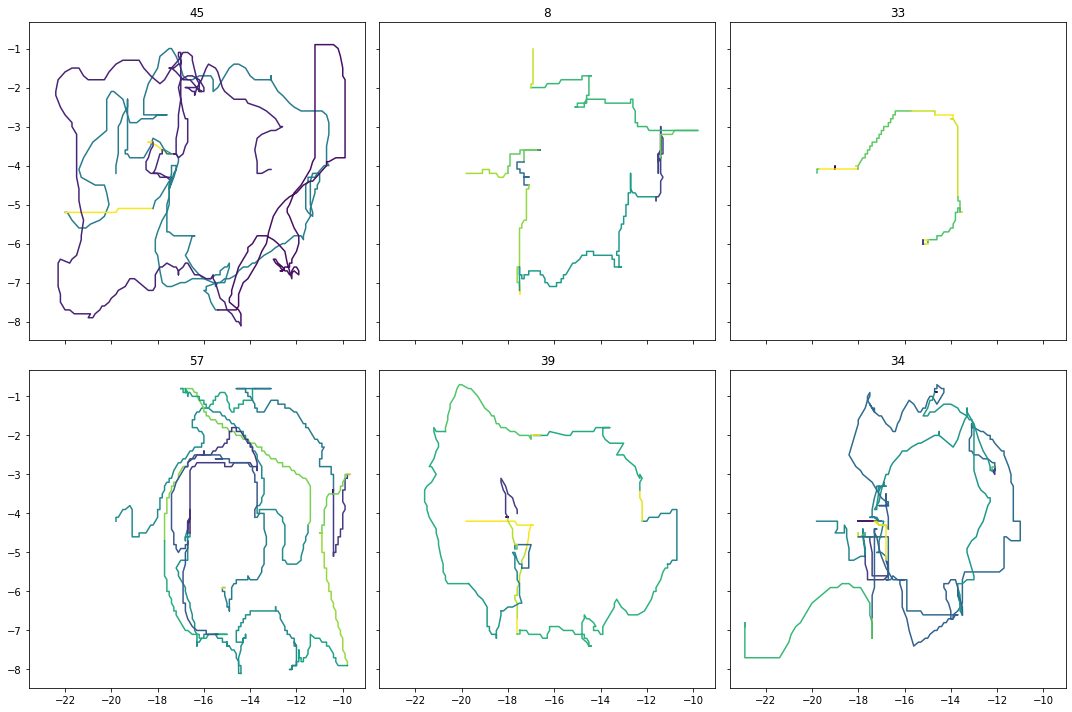

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)

norm = plt.Normalize(0, 1)
cm_norm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

for i, k in enumerate(sample[:ax.size]):
    ex = C_metrics[k]
    user_df = df.loc[k]
    for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
        path_end -= 1
        if path_end > len(ex['ma_v']):
            path_end -= window + 1
        ax[i//ax.shape[1], i % ax.shape[1]
           ].plot(user_df['C_x'].iloc[path_start:path_end], user_df['C_z'].iloc[path_start:path_end], color=cm_norm.to_rgba(ex['path_straightness'][ex['path_breaks'].index(path_start)]))
        ax[i//ax.shape[1], i % ax.shape[1]].set_title(k)

fig.tight_layout()
# fig.colorbar(cm_norm)


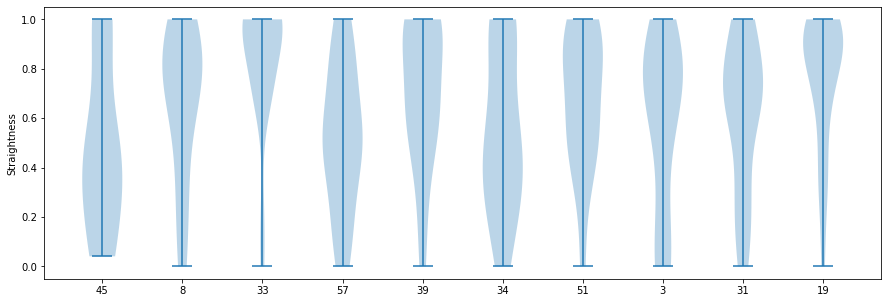

In [23]:
# Violin Plots of straightness by user, illustrate different exploration patterns per person
fig, ax = plt.subplots(figsize=(15, 5), sharey=True, sharex=True)

selected = [C_metrics[i]['path_straightness'] for i in sample]
ax.violinplot(selected);
ax.set_xticks(np.arange(1, len(sample) + 1));
ax.set_xticklabels(sample);
ax.set_ylabel('Straightness');


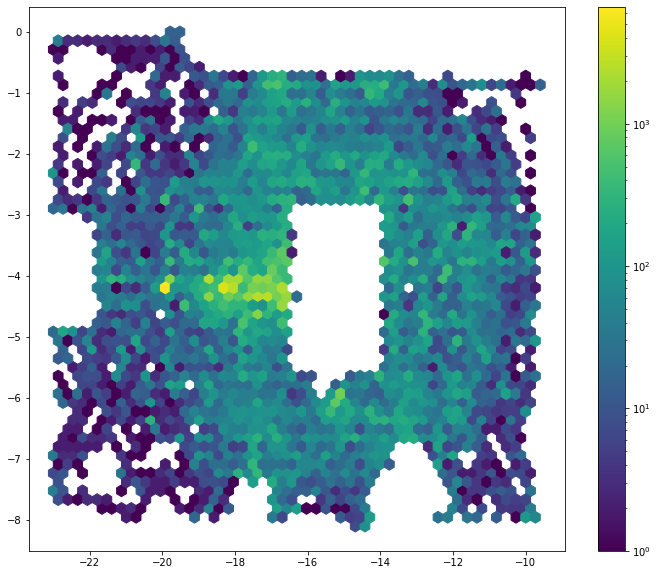

In [24]:
fig, ax = plt.subplots(figsize=(12, 10), sharey=True, sharex=True)

pc = ax.hexbin(df['C_x'], df['C_z'], cmap='viridis', mincnt=1, gridsize=50, bins='log')
fig.colorbar(pc);

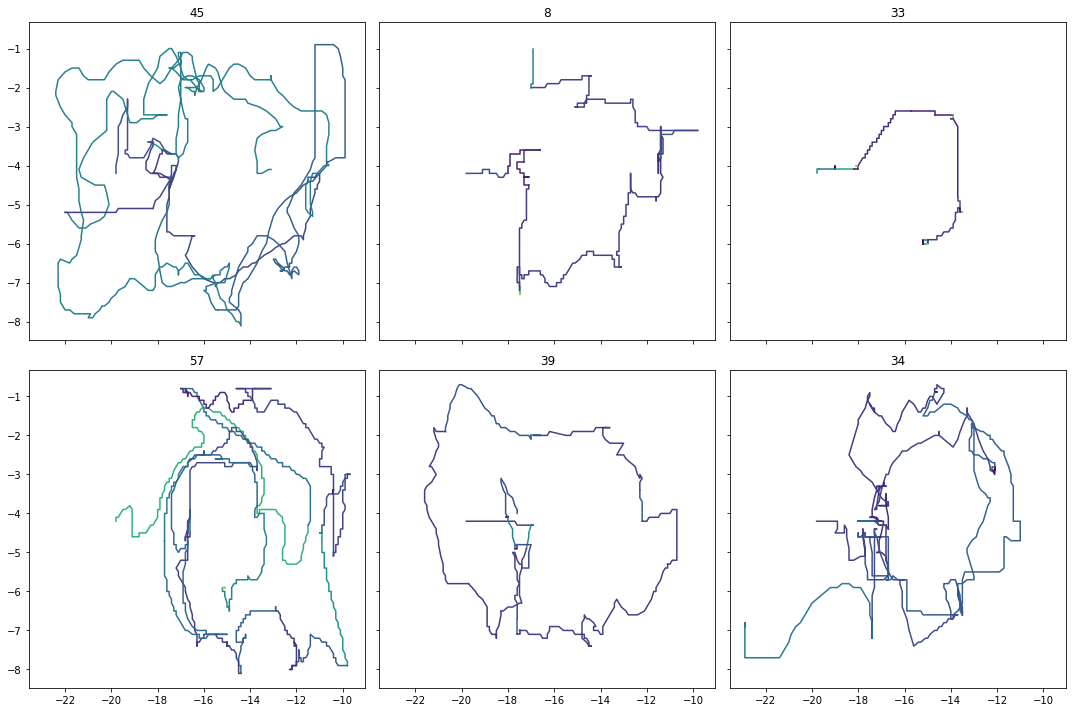

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)

maxv, minv = 0, np.inf
for k in sample:
    v = C_metrics[k]
    maxv = max(max(v['path_velocities']), maxv)
    minv = min(min(v['path_velocities']), minv)
norm = plt.Normalize(minv, maxv)
cm_norm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

for i, k in enumerate(sample[:ax.size]):
    ex = C_metrics[k]
    user_df = df.loc[k]
    for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
        path_end -= 1
        if path_end > len(ex['ma_v']):
            path_end -= window + 1
        ax[i//ax.shape[1], i % ax.shape[1]
           ].plot(user_df['C_x'].iloc[path_start:path_end], user_df['C_z'].iloc[path_start:path_end], color=cm_norm.to_rgba(ex['path_velocities'][ex['path_breaks'].index(path_start)]))
        ax[i//ax.shape[1], i % ax.shape[1]].set_title(k)

fig.tight_layout()
# fig.colorbar(cm_norm)

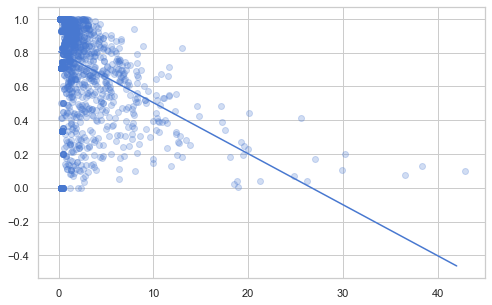

In [75]:
fig, ax = plt.subplots(figsize=(8,5))

all_t, all_sin = [], []
for k, ex in C_metrics.items():
    all_t.extend(ex['path_lengths'])
    all_sin.extend(ex['path_straightness'])

m, b = np.polyfit(all_t, all_sin, 1)
x = np.array([i for i in range(0, round(max(all_t)), 1)])

ax.scatter(all_t, all_sin, color='b', alpha=0.25)
ax.plot(x, m*x + b)

In [ ]:
# PELT Path Segmentation Algorithm
# Implementation from https://github.com/nicodesh/pelt-algorithm/blob/master/pelt.py
# https://arxiv.org/pdf/1101.1438.pdf

# def pelt(data, **kwargs):
#     # Pre-processing
#     df = pd.DataFrame(data)
#     df['squared'] = np.square(df[0])
#     df['cumsum'] = np.cumsum(df[0], axis=0)
#     df['cumsumsquared'] = np.cumsum(df['squared'], axis=0)
#     df['diviseur'] = [x for x in range(1,len(df)+1)]
#     df['mean'] = df['cumsum'] / df['diviseur']
#     df['meansquared'] = np.square(df['mean'])
#     df = df.append({
#         0:0,
#         'cumsum':0,
#         'cumsumsquared':0,
#         'diviseur':0,
#         'mean':0,
#         'meansquared':0,
#         'squared':0}, ignore_index=True)
    
#     # Penalty
#     if 'penalty' in kwargs:
#         B = kwargs['penalty']
#     else:
#         B = 2 * np.log(len(data))
    
#     # Initilization
#     Q = [-B] # Actual cost
#     CP = [-1] # Last segment position
#     T = [x for x in range(0,len(data))] # Authorized positions

#     # Parse the data
#     for pos in range(0,len(data)):
        
#         costs = []
#         min_cost_val_temp = float("inf")
#         min_cost_pos_temp = -1
        
#         # Parse all the Yi:pos that are still available
#         for i in T:
#             if i > pos:
#                 break

#             # Square sum minus N times the square mean
#             sos = df['cumsumsquared'].iloc[pos] - df['cumsumsquared'].iloc[i-1]
#             n = pos - i + 1
#             ms = (data[i:pos+1].mean())**2
#             C = sos - (n*ms)

#             # Cost test
#             temp_cost = Q[i] + C + B
#             if min_cost_val_temp > temp_cost:
#                 min_cost_val_temp = temp_cost
#                 min_cost_val_pos = i

#         # Push the smallest cost
#         Q.append(min_cost_val_temp)

#         # Push the position
#         CP.append(min_cost_val_pos)
        
#         # Prunning
#         for i in T:
#             if i >= pos:
#                 break
            
#             iplusone = i+1
#             # Square sum minus N times the square mean
#             sos = df['cumsumsquared'].iloc[pos] - df['cumsumsquared'].iloc[iplusone-1]
#             n = pos - iplusone + 1
#             ms = (data[iplusone:pos+1].mean())**2
#             C = sos - (n*ms)
                
#             if (Q[i] + C > Q[pos]):
#                 T.remove(i)
                
#     return CP

# def backtracking(CP):
#     """ Apply backtracking to a CP vector from OP algorithm. Returns a "segments" vector.
#     Args:
#      CP: array-like 1 dimension.
#     """

#     # Data length
#     n = len(CP)-1

#     # Initialization
#     segments = []
#     changepoint = CP[n]

#     # While the changepoint doesn't return the first point
#     while changepoint > 0:

#         segments.append(changepoint-1)
#         changepoint = CP[changepoint]

#     # The new vector was built with .append(), but since we parse from the end to the beginning,
#     # We need to reverse it.
#     segments.reverse()
    
#     return segments

# def plot_segments(data, segments, ylim=False):
#     """ Plot segments generated by the OP & backtracking algorithms.
#     Args:
#         data: the data used to fit the model.
#         segments: the segments returned by backtracking().
#     """
    
#     fig, ax = plt.subplots(figsize=(15,5))
#     start = 0

#     for end in segments:
#         mean = data[start:end+1].sum() / len(data[start:end+1])
#         plt.plot((start, end), (mean, mean))
#         start = end+1

#     end = len(data)-1
#     mean = data[start:end+1].sum() / len(data[start:end+1])
#     plt.plot((start, end), (mean, mean))
    
#     if ylim != False:
#         plt.ylim(ylim)
#     plt.show()

# cp = pelt(np.array(C_metrics['34']['v']))
# segments = backtracking(cp)
# plot_segments(np.array(C_metrics['34']['v']), segments)

## Similarity Analysis of Movement Data

In [27]:
# Create dataframe of paths (metrics and coordinate arrays)
from rdp import rdp


path_df = pd.DataFrame(columns=['user_id', 'straightness', 'average_velocity', 'time', 'length',
                                'displacement', 'cumul_x_mov', 'cumul_z_mov', 'C_coords', 'L_coords', 'C_coords_rdp', 'gender'])

for k, ex in C_metrics.items():
    user_df = df.loc[k]
    for i, (path_start, path_end) in enumerate(zip(ex['path_breaks'], ex['path_breaks'][1:])):
        row = {}
        row['user_id'] = k
        row['straightness'] = ex['path_straightness'][i]
        row['average_velocity'] = ex['path_velocities'][i]
        row['time'] = ex['path_times'][i]
        row['length'] = ex['path_lengths'][i]
        row['displacement'] = ex['path_displacements'][i]
        row['C_coords'] = user_df.iloc[path_start:path_end][['C_x', 'C_z']].to_numpy()
        row['L_coords'] = user_df.iloc[path_start:path_end][['L_x', 'L_y', 'L_z']].to_numpy()
        row['C_coords_rdp'] = rdp(row['C_coords'], 0.0001)
        row['cumul_x_mov'] = row['cumul_z_mov'] = 0
        row['gender'] = user_df.iloc[0]['gender']
        # for j in range(path_start + 1, path_end):
        #     row['cumul_x_mov'] += abs(user_df.iloc[j]['C_x'] - user_df.iloc[j - 1]['C_x'])
        #     row['cumul_y_mov'] += abs(user_df.iloc[j]['C_y'] - user_df.iloc[j - 1]['C_y'])
        #     row['cumul_z_mov'] += abs(user_df.iloc[j]['C_z'] - user_df.iloc[j - 1]['C_z'])
        path_df = path_df.append(row, ignore_index=True)


In [28]:
path_df.head()

user_id  straightness  average_velocity   time    length  displacement  \
0       6      0.935711          2.482873  3.723  1.500000      1.403567   
1       6      0.403461          0.930012  5.635  3.965685      1.600000   
2       6      0.853923          2.236377  2.639  0.682843      0.583095   
3       6      0.437625          0.856868  3.989  1.965685      0.860233   
4       6      0.574745          1.440744  5.800  3.282843      1.886796   

  cumul_x_mov cumul_z_mov                                           C_coords  \
0           0           0  [[-19.8, -4.2], [-19.7, -4.2], [-19.6, -4.2], ...   
1           0           0  [[-18.4, -4.1], [-18.2, -4.1], [-18.2, -4.1], ...   
2           0           0  [[-18.4, -2.5], [-18.4, -2.6], [-18.3, -2.7], ...   
3           0           0  [[-18.1, -3.0], [-18.0, -3.0], [-18.0, -3.0], ...   
4           0           0  [[-18.8, -2.5], [-18.7, -2.5], [-18.7, -2.5], ...   

                                            L_coords  \
0  [[-15.5, 2.1, -4.0], [-15.5, 2.1, -4.0], [-15....   
1  [[-15.5, 2.6, -4.9], [-15.5, 2.5, -4.9], [-15....   
2  [[-17.0, 1.4, -0.3], [nan, nan, nan], [nan, na...   
3  [[nan, nan, nan], [nan, nan, nan], [nan, nan, ...   
4  [[-9.3, 2.1, -6.0], [-9.3, 2.1, -6.0], [-9.3, ...   

                                        C_coords_rdp gender  
0  [[-19.8, -4.2], [-19.6, -4.2], [-19.6, -4.1], ...      m  
1  [[-18.4, -4.1], [-17.9, -4.1], [-18.0, -4.1], ...      m  
2  [[-18.4, -2.5], [-18.4, -2.6], [-18.3, -2.7], ...      m  
3  [[-18.1, -3.0], [-18.0, -3.0], [-18.0, -2.9], ...      m  
4  [[-18.8, -2.5], [-18.5, -2.5], [-18.5, -2.6], ...      m

23 4
120 32
184 21
156 8
97 2
110 3


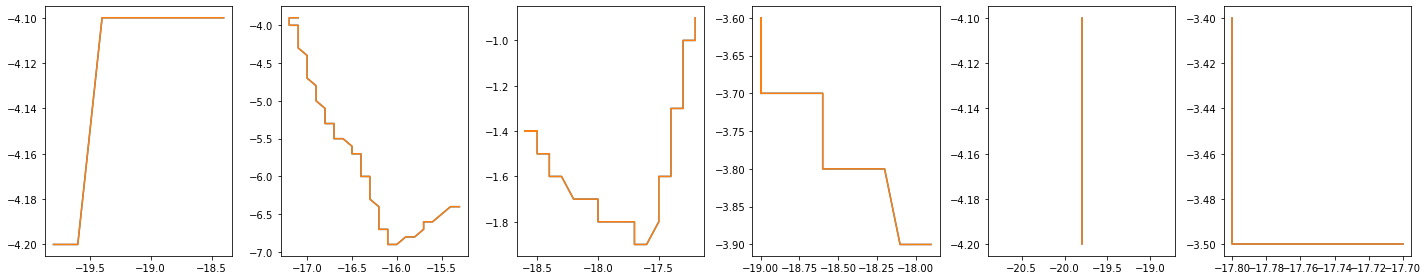

In [29]:
fig, ax = plt.subplots(1, 6, figsize=(20,4))

for ax_i, i in enumerate(random.sample([i for i in range(len(path_df))], ax.shape[0])):
    line = path_df.iloc[i]['C_coords']
    ax[ax_i].plot(line[:, 0], line[:, 1])
    line2 = path_df.iloc[i]['C_coords_rdp']
    ax[ax_i].plot(line2[:, 0], line2[:, 1])
    print(len(line), len(line2))

fig.tight_layout()

1    889
6    454
3    149
2     63
4     45
0     12
5      9
Name: cluster, dtype: int64

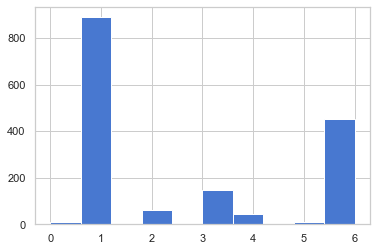

In [70]:
# Cluster paths by metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

n_clusters = 7

clustering = KMeans(n_clusters=n_clusters, n_init=50, max_iter=500, ).fit(path_df[['straightness', 'average_velocity', 'displacement', 'length', 'time']].to_numpy())
# clustering = DBSCAN(eps=0.4, min_samples=5).fit(path_df[['straightness', 'average_velocity', 'displacement', 'length', 'time']].to_numpy())
path_df['cluster'] = clustering.labels_
path_df['cluster'] = path_df['cluster'].astype("category")
path_df['cluster'].hist()

n_clusters = len(np.unique(clustering.labels_))
path_df['cluster'].value_counts()

### Frechet Path Distances and BDSCAN Clustering

Not as effective at discerning different path types (i.e. short sinuous ones vs long wandering)

In [71]:
# from tqdm import tqdm
# import multiprocessing as mp

## Cluster by path similarity measures (frechet)
# import similaritymeasures

# n = len(path_df)

# pbar = tqdm(total=n)

# def dist_row(i):
#     r = np.zeros(n)
#     for j in range(i + 1, n):
#         r[j] = similaritymeasures.frechet_dist(
#             path_df.iloc[i]['C_coords_rdp'], path_df.iloc[j]['C_coords_rdp'])
#     pbar.update(1)
#     return r


# pool = mp.Pool(4)
# results = pool.map(dist_row, range(n))
# results = np.array(results)
# np.save('frechet_matrix.npy', results)
# for i in range(n):
#     for j in range(i+1, n):
#         results[j, i] = results[i, j]

# clustering = DBSCAN(eps=0.5, min_samples=5, metric='precomputed')
# clustering.fit(results)
# path_df['cluster'] = clustering.labels_ + 1

# path_df['cluster'].hist()

# n_clusters = len(np.unique(clustering.labels_))
# path_df['cluster'].value_counts()


### Visualising path clusters

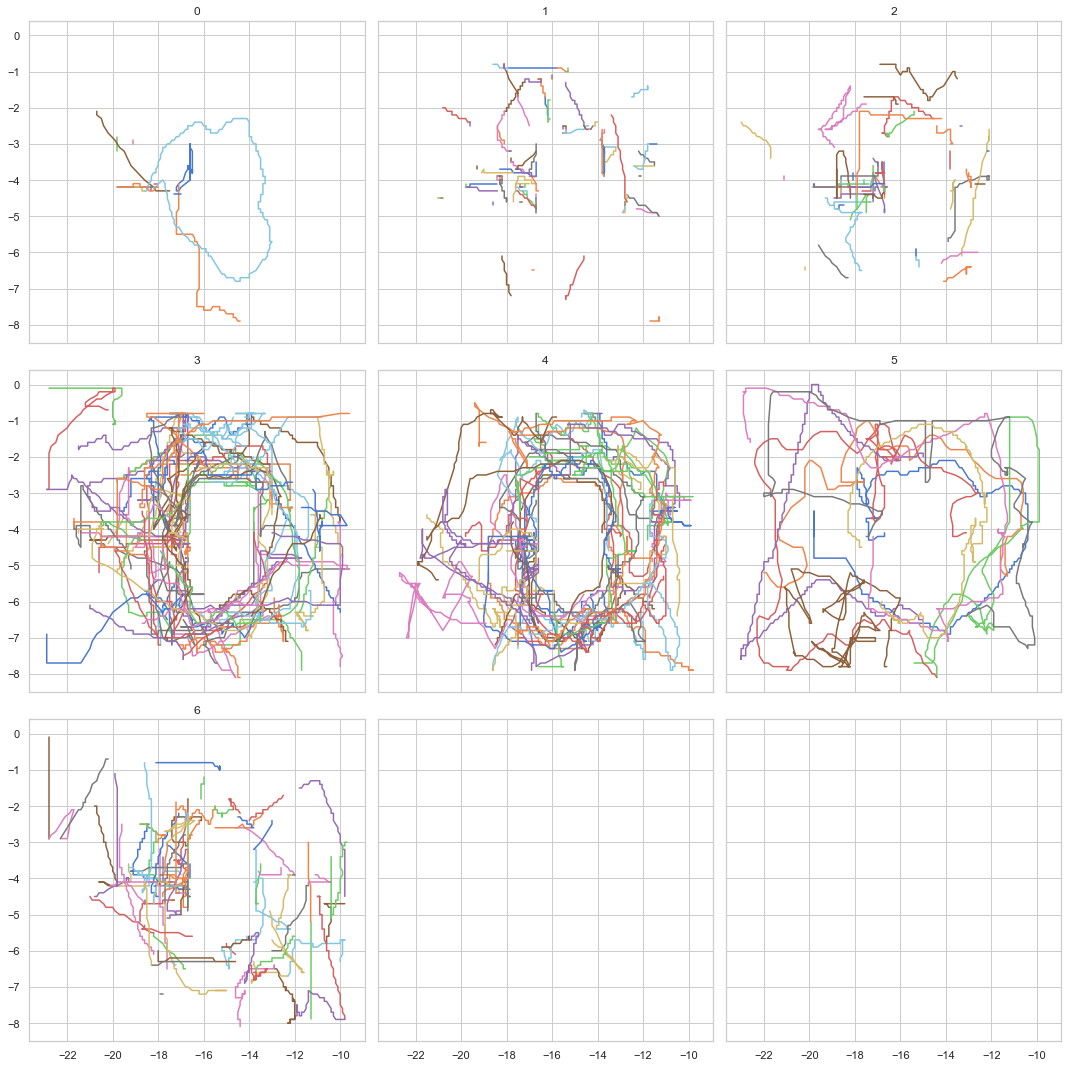

In [72]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharey=True, sharex=True)

for i in range(n_clusters):
    # Plot only 100 from each cluster to reduce noise
    for line in path_df[path_df['cluster'] == i]['C_coords_rdp'].to_list()[:100]:
        ax[i//ax.shape[1], i % ax.shape[1]].plot(line[:, 0], line[:, 1])
    ax[i//ax.shape[1], i % ax.shape[1]].set_title(i)
fig.tight_layout()

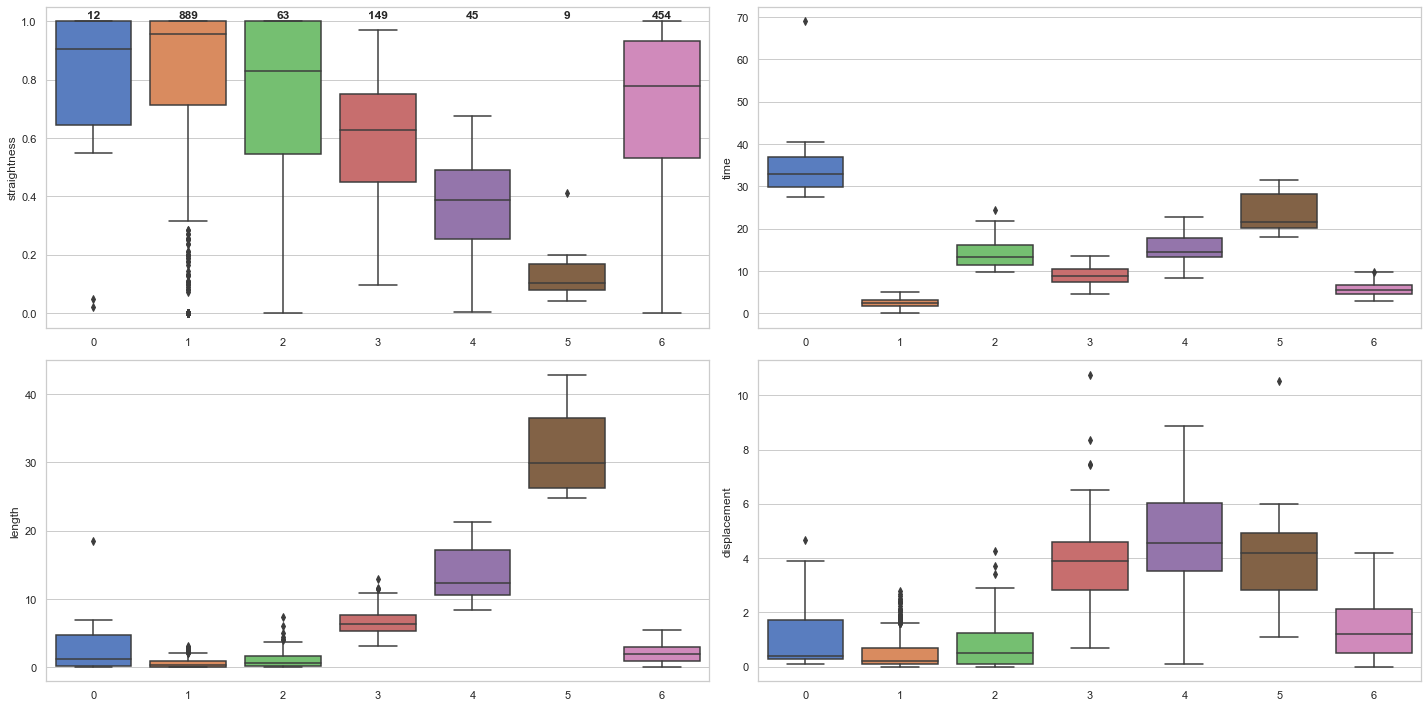

In [73]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme(style="whitegrid", palette="muted")

nobs = [str(len(path_df[path_df['cluster'] == x])) for x in range(n_clusters)]

sns.boxplot(data=path_df, x="cluster", y="straightness", ax=ax[0, 0])

pos = range(len(nobs))
for tick,label in zip(pos,ax[0, 0].get_xticklabels()):
    ax[0, 0].text(pos[tick], 1.01, nobs[tick], horizontalalignment='center', weight='bold')
ax[0, 0].set_xlabel('')

sns.boxplot(data=path_df, x="cluster", y="time", ax=ax[0, 1])
ax[0, 1].set_xlabel('')

sns.boxplot(data=path_df, x="cluster", y="length", ax=ax[1, 0])
ax[1, 0].set_xlabel('')

sns.boxplot(data=path_df, x="cluster", y="displacement", ax=ax[1, 1])
ax[1, 1].set_xlabel('')

fig.tight_layout()

<AxesSubplot:xlabel='straightness', ylabel='length'>

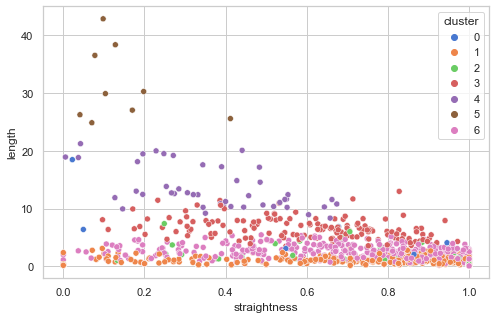

In [74]:
fig, ax = plt.subplots(figsize=(8,5))

sns.scatterplot(data=path_df, x='straightness', y='length', hue='cluster')

In [166]:
# HMM of Path States

from hmmlearn import hmm

sequence = []
lengths = []

for id in df.reset_index().id.unique():
    for _, path in path_df[path_df.user_id == id].iterrows():
        sequence.append([[path['cluster']]] * len(path['C_coords']))
        lengths.append(len(path['C_coords']))

sequence = np.concatenate(sequence)
lr = hmm.MultinomialHMM(n_components=4)
lr.fit(sequence, lengths)

MultinomialHMM(n_components=4,
               random_state=RandomState(MT19937) at 0x7FA552CAF270)

In [190]:
print(lr.transmat_, '\n\n', lr.startprob_)

[[1.00000000e+000 8.64774400e-136 3.39682130e-061 2.78704906e-060]
 [1.38774993e-133 1.00000000e+000 6.48757073e-061 7.46975093e-072]
 [1.26895653e-059 4.76405500e-061 7.40191219e-001 2.59808781e-001]
 [1.92439270e-058 6.92538127e-072 5.21985042e-001 4.78014958e-001]] 

 [0.05181986 0.66810611 0.19632714 0.08374689]


In [188]:
x, z = lr.sample(100)
z

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# POG Movement Analysis

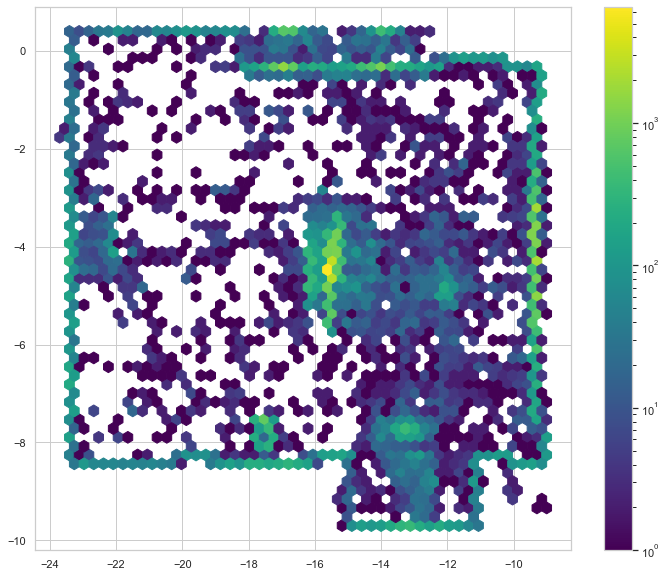

In [65]:
fig, ax = plt.subplots(figsize=(12, 10), sharey=True, sharex=True)

pc = ax.hexbin(df['L_x'], df['L_z'], cmap='viridis', mincnt=1, gridsize=50, bins='log')
fig.colorbar(pc);

In [ ]:
# to correlate the full camera position data with the interrupted PoG data we use the nearest index matched by time
def get_nearest_time_index(time, L_times):
    return np.min(np.abs(np.array(L_times) - time))

In [ ]:
from celluloid import Camera

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
norm = plt.Normalize(0, 1)
cm_norm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

k='40'
ex = C_metrics[k]
user_df = df.loc[k]

ax.set_xlabel('C_x')
ax.set_ylabel('C_z')
ax.set_zlabel('C_y')
ax.grid(False)
ax.view_init(20, 280)

for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
    path_end -= 1

    ax.plot(user_df['C_x'].iloc[path_start:path_end], user_df['C_z'].iloc[path_start:path_end], user_df['C_y'].iloc[path_start:path_end], \
        color=cm_norm.to_rgba(ex['path_straightness'][ex['path_breaks'].index(path_start)]), \
            linewidth=3)

# for i, row in user_df[~user_df['L_x'].isna()].iterrows():
#     ax.plot((row['C_x'], row['L_x']), (row['C_z'], row['L_z']), (row['C_y'], row['L_y']), color='blue', alpha=0.1)



In [ ]:
# Do users tend to walk towards where they are looking

# average cos(orientation of movement - orientation of eye direction)

